In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot ; jtplot.style()
import hddm
from sklearn.decomposition import PCA
import pipeline
from glob import glob
from os import chdir ; chdir('/Users/albertwakhloo/Desktop/theoretical_neuroscience/neuromatch/steinmetz full/allData/all dat')

#### Pull out mice that have basal ganglia recordings. 

In [100]:
basal_ganglia = np.array(["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"])
f = glob('*')
filt = pipeline.filt(f, regions_to_pull = basal_ganglia )
filt[filt.n_relevant_probes >= 2.]

Origin                abbrev  n_relevant_probes
8       Hench_2017-06-18      Hench_2017-06-18                3.0
20   Richards_2017-11-01   Richards_2017-11-01                2.0
28  Lederberg_2017-12-11  Lederberg_2017-12-11                5.0
29      Tatum_2017-12-09      Tatum_2017-12-09                2.0

In [101]:
subset = filt[filt.n_relevant_probes >= 2].Origin
neur, stim = pipeline.processer(subset, truncate = 500, mr_clean = True)

Mapping neurons from Hench_2017-06-18 to channels ... 
Mapping channels to brain areas ...
Mapping neurons from Richards_2017-11-01 to channels ... 
Mapping channels to brain areas ...
Mapping neurons from Lederberg_2017-12-11 to channels ... 
Mapping channels to brain areas ...
Mapping neurons from Tatum_2017-12-09 to channels ... 
Mapping channels to brain areas ...
Getting behavioral data ...
~~~ OOOoOOOOooOoOOOOOOOOOOoooOooOOOOOOo ~~~


/Users/albertwakhloo/opt/miniconda3/envs/pd1hddm36/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [17]:
areas_per_mouse = {}
for mouse, area in neur.groupby('maus') : 
    areas_per_mouse[mouse] = area.area.unique()
areas_per_mouse

{0: array(['LSc', 'PT', 'MOp', 'root', 'CP', 'LSr'], dtype=object),
 1: array(['CP', 'EP', 'LGd', 'VPM', 'CA1', 'root', 'ZI', 'SNr', 'CA3'],
       dtype=object),
 2: array(['CP', 'SI', 'ACB', 'OT', 'ZI', 'root', 'SNr', 'TH', 'CA3', 'LGd'],
       dtype=object),
 3: array(['BLA', 'GPe', 'root', 'CA3', 'LGd', 'SNr'], dtype=object)}

#### Start by grabbing one of the most commonly recorded areas. Grab the average spike rate over a 200ms time bin following stimulus onset. We could also use a gaussian window here...

In [18]:
subset = neur[neur.area == 'CA3'].copy() #grab mice with CA3 recordings
subset.head()

spike_t area maus  neuron
1665493  1.162356  CA3    1   667.0
1665510  1.171223  CA3    1   849.0
1665629  1.217189  CA3    1   523.0
1665708  1.249789  CA3    1   590.0
1665721  1.255123  CA3    1   849.0

In [42]:
dat = pipeline.extract_trial_stim_avg(subset, stim, ['CA3']) # pull spike rates

Generating mouse 0 spike rate data ...
Generating mouse 1 spike rate data ...
Generating mouse 2 spike rate data ...
Generating mouse 3 spike rate data ...
~~~ young success ~~~~


In [22]:
mice = stim[stim.subj_idx.isin(subset.maus.unique())].copy() #grab the three mice with CA3 rec from stim
mice['striate'] = dat.CA3.values #add mean ca3 activation for 200 ms bin following stim onset
mice.head()

rt  subj_idx  response  response_type  split_by  feedback  q_init  \
109  1.079599       1.0         1            1.0         1       1.0     0.7   
110  0.538964       1.0         0           -1.0         0       1.0     0.7   
111  0.811148       1.0         1            1.0         1       1.0     0.7   
112  1.019877       1.0         1            1.0         1       1.0     0.7   
116  0.878477       1.0         0           -1.0         0       1.0     0.7   

      stimtime   striate  
109  46.777708  1.282051  
110  51.467933  1.410256  
111  58.562284  1.025641  
112  71.752664  2.179487  
116  90.210209  1.410256

In [30]:
print(mice.striate.min())
print(mice.striate.max())
print(mice.striate.mean())

0.0
7.714285714285714
2.7378649696900617


In [32]:
pipeline.extract_trial_stim_avg?

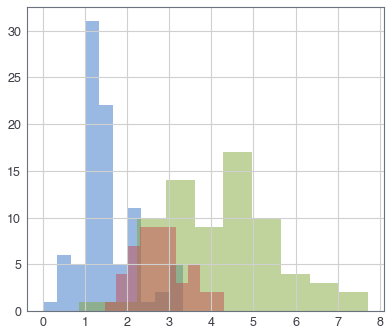

In [31]:
for i, dat in mice.groupby('subj_idx').striate : #plot spike rates for each mouse over all trls
    len(dat)
    dat.plot(space, alpha = 0.5)

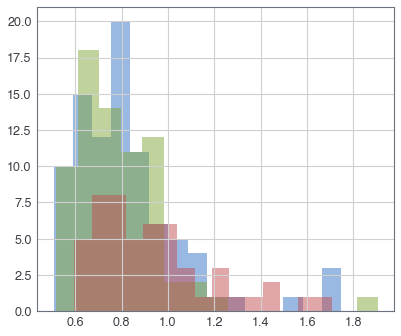

In [23]:
for i, dat in mice.groupby('subj_idx').rt : 
    dat.hist(bins = 15, alpha = 0.5)

In [33]:
m = hddm.HDDMrlRegressor(mice, 'v ~ striate', include = 'alpha')
m.find_starting_values()
m.sample(1500, burn = 500)

Adding these covariates:
['v_Intercept', 'v_striate']
 [-----------------100%-----------------] 1500 of 1500 complete in 652.6 sec

In [34]:
def plot_posterior(param, trace, bins = 50) : 
    _, ax = plt.subplots(1, 2, figsize = (20, 7))
    x = np.arange(len(trace))
    ax[0].hist(trace[param], bins = bins)
    ax[1].plot(x, trace[param])
trace = m.get_group_traces()

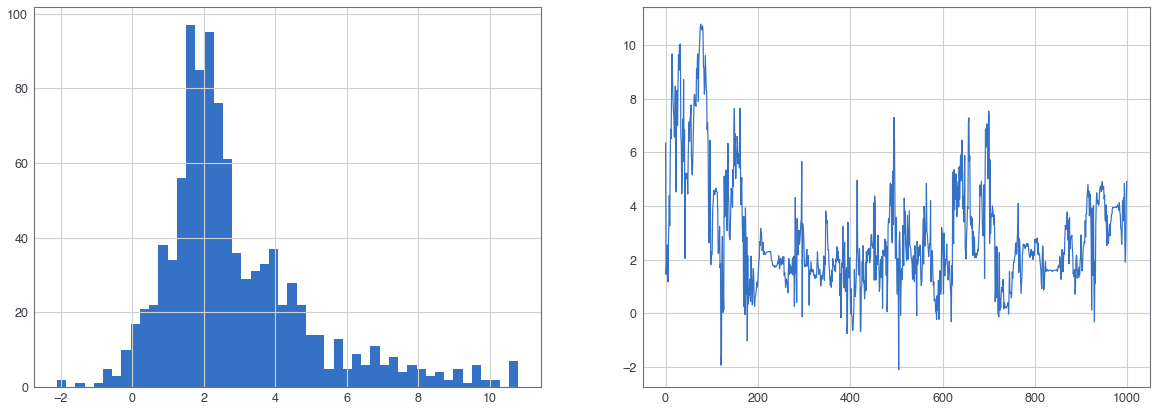

In [35]:
plot_posterior('v_Intercept', trace)

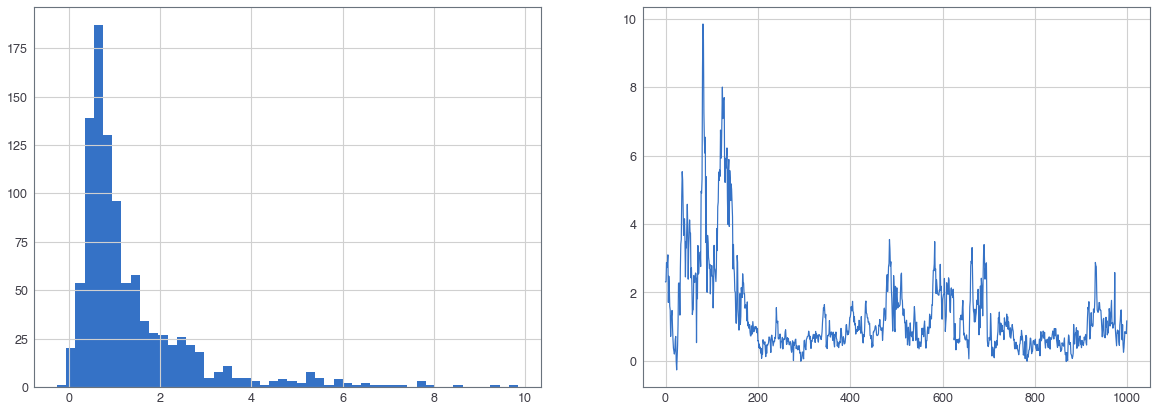

In [36]:
plot_posterior('v_striate', trace)

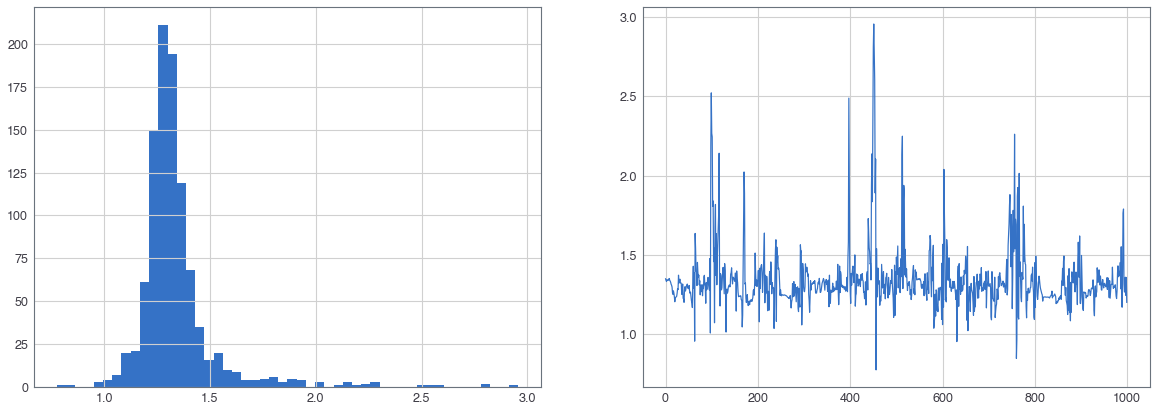

In [37]:
plot_posterior('a', trace)

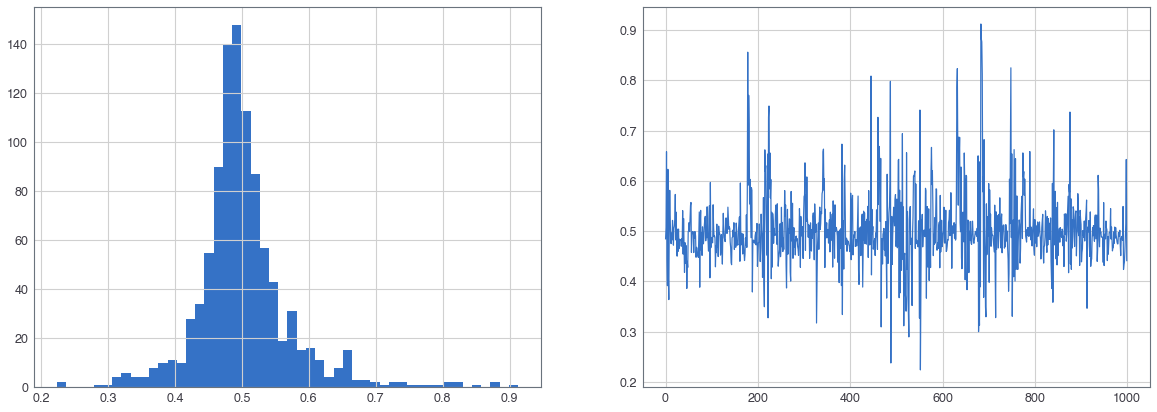

In [38]:
plot_posterior('t', trace)

In [39]:
m.get_group_nodes()

knode_name stochastic observed   subj             node  \
a                              a       True    False  False                a   
a_std                      a_std       True    False  False            a_std   
t                              t       True    False  False                t   
t_std                      t_std       True    False  False            t_std   
alpha                      alpha       True    False  False            alpha   
alpha_std              alpha_std       True    False  False        alpha_std   
v_Intercept          v_Intercept       True    False  False      v_Intercept   
v_Intercept_std  v_Intercept_std       True    False  False  v_Intercept_std   
v_striate              v_striate       True    False  False        v_striate   

                tag depends hidden  rt  subj_idx  ...  striate      mean  \
a                ()      []  False NaN       NaN  ...      NaN  1.340785   
a_std            ()      []  False NaN       NaN  ...      NaN  0.198970   
t                ()      []  False NaN       NaN  ...      NaN  0.502216   
t_std            ()      []  False NaN       NaN  ...      NaN  0.121564   
alpha            ()      []  False NaN       NaN  ...      NaN  7.211075   
alpha_std        ()      []  False NaN       NaN  ...      NaN  4.338486   
v_Intercept      ()      []  False NaN       NaN  ...      NaN  2.883545   
v_Intercept_std  ()      []  False NaN       NaN  ...      NaN  1.177162   
v_striate        ()      []  False NaN       NaN  ...      NaN  1.359185   

                       std      2.5q       25q       50q        75q  \
a                 0.194499  1.106690  1.250219  1.306040   1.368502   
a_std             0.294495  0.005489  0.044708  0.099189   0.212105   
t                 0.071712  0.366597  0.469409  0.493695   0.526168   
t_std             0.140624  0.023208  0.047863  0.077704   0.143285   
alpha            12.349808 -2.588596 -0.765606  0.897766  12.361823   
alpha_std         5.230927  0.116037  0.663159  1.990504   6.310205   
v_Intercept       2.086998 -0.031513  1.602222  2.297788   3.813576   
v_Intercept_std   0.951265  0.025965  0.420313  0.962653   1.757080   
v_striate         1.321917  0.172290  0.593476  0.878895   1.600909   

                     97.5q    mc err           map  
a                 1.891136  0.011962  1.335505e+00  
a_std             1.168983  0.022438  3.938292e-02  
t                 0.666650  0.003110  4.886931e-01  
t_std             0.460016  0.010040  3.833759e-02  
alpha            40.901381  1.135685  2.338134e-02  
alpha_std        18.659055  0.445867  6.616414e-03  
v_Intercept       8.745227  0.186647  2.029184e+00  
v_Intercept_std   3.600614  0.074455  9.478319e-03  
v_striate         5.530513  0.122572  2.174195e-11  

[9 rows x 26 columns]

#### Now we'll average over all basal ganglia neuron responses for each mouse that has at least two areas recorded. 

In [49]:
dat = pipeline.extract_trial_stim_avg(neur, stim, basal_ganglia)

Generating mouse 0 spike rate data ...
Generating mouse 1 spike rate data ...
Generating mouse 2 spike rate data ...
Generating mouse 3 spike rate data ...
~~~ young success ~~~~


In [54]:
dat.loc[:, dat.columns != 'maus'].head()

LSc        CP  LSr  SNr  SI  ACB  OT  GPe
0  2.633929  2.218468  3.6  NaN NaN  NaN NaN  NaN
1  1.875000  2.072072  2.0  NaN NaN  NaN NaN  NaN
2  0.892857  2.027027  3.2  NaN NaN  NaN NaN  NaN
3  2.008929  2.443694  3.8  NaN NaN  NaN NaN  NaN
4  1.383929  1.317568  2.4  NaN NaN  NaN NaN  NaN

In [72]:
mean_striate_activation = dat.loc[:, dat.columns != 'maus'].mean(axis = 1)

In [81]:
mice = stim.copy()
mice['striate'] = mean_striate_activation.values
mice.tail()

rt  subj_idx  response  response_type  split_by  feedback  q_init  \
441  0.981080       3.0         0           -1.0         0       1.0     0.7   
444  1.229458       3.0         0           -1.0         0       1.0     0.7   
445  0.769158       3.0         0           -1.0         0       1.0     0.7   
447  1.268187       3.0         1            1.0         1       1.0     0.7   
448  1.567003       3.0         0           -1.0         1       0.0     0.7   

       stimtime    striate  
441  466.254045  10.685330  
444  482.404499  10.703125  
445  486.314528  12.566840  
447  494.065630  10.910590  
448  496.650267  10.971788

In [89]:
m = hddm.HDDMrlRegressor(mice, 'v ~ striate', include = 'alpha')
m.find_starting_values()
m.sample(30000, burn = 13000)

Adding these covariates:
['v_Intercept', 'v_striate']


/Users/albertwakhloo/opt/miniconda3/envs/pd1hddm36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/albertwakhloo/opt/miniconda3/envs/pd1hddm36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


 [-----------------100%-----------------] 15001 of 15000 complete in 8552.2 sec-----------      29%                  ] 4433 of 15000 complete in 2922.1 sec[-----------------48%                  ] 7205 of 15000 complete in 4385.5 sec[-----------------92%--------------    ] 13804 of 15000 complete in 7957.7 sec[-----------------94%----------------  ] 14218 of 15000 complete in 8136.8 sec

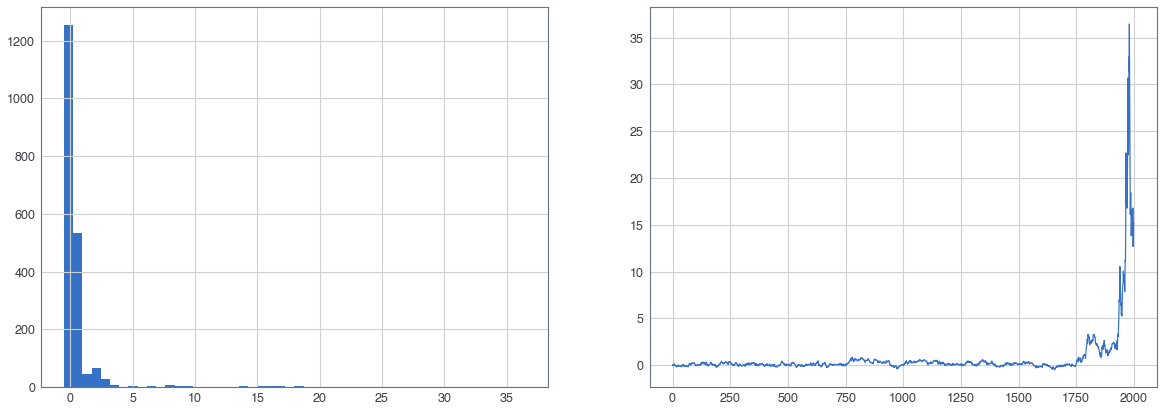

In [93]:
trace = m.get_group_traces()
plot_posterior('v_striate', trace[:])

In [87]:
m.get_group_nodes()

knode_name stochastic observed   subj             node  \
a                              a       True    False  False                a   
a_std                      a_std       True    False  False            a_std   
t                              t       True    False  False                t   
t_std                      t_std       True    False  False            t_std   
alpha                      alpha       True    False  False            alpha   
alpha_std              alpha_std       True    False  False        alpha_std   
v_Intercept          v_Intercept       True    False  False      v_Intercept   
v_Intercept_std  v_Intercept_std       True    False  False  v_Intercept_std   
v_striate              v_striate       True    False  False        v_striate   

                tag depends hidden  rt  subj_idx  ...  striate       mean  \
a                ()      []  False NaN       NaN  ...      NaN   1.468168   
a_std            ()      []  False NaN       NaN  ...      NaN   0.381818   
t                ()      []  False NaN       NaN  ...      NaN   0.502740   
t_std            ()      []  False NaN       NaN  ...      NaN   0.073209   
alpha            ()      []  False NaN       NaN  ...      NaN  15.689942   
alpha_std        ()      []  False NaN       NaN  ...      NaN   5.853742   
v_Intercept      ()      []  False NaN       NaN  ...      NaN   0.573560   
v_Intercept_std  ()      []  False NaN       NaN  ...      NaN   1.712016   
v_striate        ()      []  False NaN       NaN  ...      NaN   1.492203   

                       std      2.5q       25q       50q        75q  \
a                 0.223388  1.130419  1.341157  1.431568   1.552133   
a_std             0.297749  0.099211  0.201928  0.290123   0.449249   
t                 0.042907  0.429056  0.481222  0.499923   0.519357   
t_std             0.063859  0.018840  0.037187  0.054753   0.085712   
alpha            26.357884 -4.180869 -0.640707  1.262557  25.442444   
alpha_std         5.136835  0.157000  2.038020  4.289783   8.048557   
v_Intercept       2.659985 -4.725419 -1.195342  0.428809   2.514588   
v_Intercept_std   1.210774  0.122594  0.722750  1.490783   2.480975   
v_striate         1.436319 -0.081126  0.394397  1.143566   2.335939   

                     97.5q    mc err           map  
a                 2.063689  0.006715  1.392047e+00  
a_std             1.185349  0.013714  1.035458e-01  
t                 0.603939  0.001280  4.994907e-01  
t_std             0.243064  0.003205  3.824006e-02  
alpha            90.498126  2.553373  2.267717e-02  
alpha_std        19.120908  0.377694  5.858349e-03  
v_Intercept       5.795040  0.236449  2.028579e+00  
v_Intercept_std   4.344910  0.091476  8.275046e-03  
v_striate         4.392245  0.135922  2.174195e-11  

[9 rows x 26 columns]

In [88]:
m.dic

-333.90386200564114

#### Instead of taking mean spiking rate across all areas, we c